<a href="https://colab.research.google.com/github/swilsonmfc/deeplearning/blob/master/JenaKerasRNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Temperature Dataset
* Pull a dataset of climate data
  * Taken from Jena, Germany from 2009-2016
  * Observation taken ever 10 minutes
* Attempt to predict temperature 1 day in advance
* Use prior 10 days to predict
* From Deep Learning with Python (Chollet)

# Setup

In [2]:
import numpy as np
import matplotlib.pyplot as plt

from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

Using TensorFlow backend.


In [0]:
from tensorflow.python.util import deprecation
deprecation._PRINT_DEPRECATION_WARNINGS = False

# Data

In [4]:
!wget 'https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip'
!unzip jena_climate_2009_2016.csv.zip

--2019-12-24 02:26:06--  https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.80.139
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.80.139|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13568290 (13M) [application/zip]
Saving to: ‘jena_climate_2009_2016.csv.zip’

jena_climate_2009_2 100%[===================>]  12.94M  19.6MB/s    in 0.7s    

2019-12-24 02:26:07 (19.6 MB/s) - ‘jena_climate_2009_2016.csv.zip’ saved [13568290/13568290]

Archive:  jena_climate_2009_2016.csv.zip
  inflating: jena_climate_2009_2016.csv  


In [5]:
with open('jena_climate_2009_2016.csv') as f:
  data = f.read()
  lines = data.split('\n')
  header = lines[0].split(',')
  lines = lines[1:]
print(header)

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']


In [0]:
fp_data = np.zeros((len(lines), len(header) - 1))
for i, line in enumerate(lines):
  values = [float(x) for x in line.split(',')[1:]]
  fp_data[i, :] = values

# EDA

Text(0, 0.5, 'Temp Celcius')

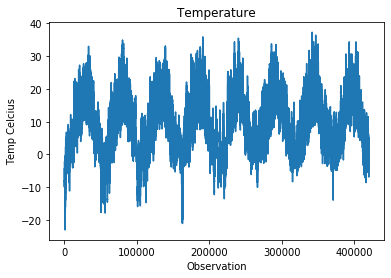

In [5]:
temp = fp_data[:, 1] #Temp Celcius
plt.plot(range(len(temp)), temp)
plt.title('Temperature')
plt.xlabel('Observation')
plt.ylabel('Temp Celcius')

Text(0, 0.5, 'Temp Celcius')

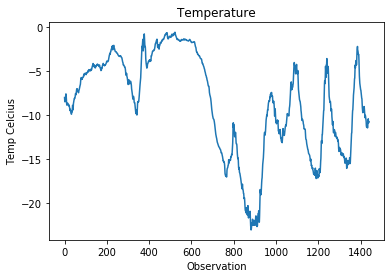

In [6]:
plt.plot(range(1440), temp[:1440])
plt.title('Temperature')
plt.xlabel('Observation')
plt.ylabel('Temp Celcius')

# Normalize Data
* Compute means on 1st 200,000 rows
* Compute std dev on 1st 200,000 rows
* Center and standardize

In [0]:
colmeans = fp_data[:200000].mean(axis=0)
fp_data -= colmeans
colsstd = fp_data[:200000].std(axis=0)
fp_data /= colsstd

# Generator
Takes In:
* Data
* Lookback:  How many steps in past
* Delay: How many steps in future
* Min_Index & Max_Index: Delimit training, validation, test
* Shuffle: Should we shuffle or in chronological order
* Batch_size: Number of samples per batch
* Step: Period in timesteps to sample (6 = 1/hour)

In [0]:
def generator(data, lookback, delay, min_index, max_index, shuffle=False, bs=128, steps=6):
  if max_index is None:
    max_index = len(data) - delay - 1
  i = min_index + lookback

  while 1:
    if shuffle: 
      rows = np.random.randint(min_index + lookback, max_index, size=bs)
    else:
      if i + bs >= max_index:
        i = min_index + lookback
      rows = np.arange(i, min(i + bs, max_index))
      i += len(rows)
    
    samples = np.zeros((len(rows), lookback // step, data.shape[-1]))
    targets = np.zeros((len(rows), ))

    for j, row in enumerate(rows):
      indices = range(rows[j] - lookback, rows[j], step)
      samples[j] = data[indices]
      targets[j] = data[rows[j] + delay][1]
    yield samples, targets

# Train, Test, Validation

In [0]:
lookback = 1440
step = 6
delay = 144
batch_size = 128

train_gen = generator(fp_data,
                      lookback=lookback,
                      delay=delay,
                      min_index=0,
                      max_index=200000,
                      shuffle=True,
                      steps=step,
                      bs=batch_size)

val_gen = generator(fp_data,
                      lookback=lookback,
                      delay=delay,
                      min_index=200001,
                      max_index=300000,
                      steps=step,
                      bs=batch_size)

test_gen = generator(fp_data,
                      lookback=lookback,
                      delay=delay,
                      min_index=300001,
                      max_index=None,
                      steps=step,
                      bs=batch_size)

val_steps  = (300000 - 200001 - lookback) // batch_size
test_steps = (len(fp_data) - 300001 - lookback) // batch_size

# Naive Baseline
* Take today's temperature and use that as our prediction

In [10]:
def eval_naive():
  batch_maes = []
  for step in range(val_steps):
    samples, targets = next(val_gen)
    preds = samples[:, -1, 1]
    mae = np.mean(np.abs(preds, targets))
    batch_maes.append(mae)
  print(np.mean(batch_maes))
eval_naive()

0.7642865104804654


# Dense Model
* Dense model will train quickly, but not expecting high performance

In [11]:
model = Sequential()
model.add(layers.Flatten(input_shape=(lookback // step, fp_data.shape[-1])))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(1))
model.summary()




Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 3360)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                107552    
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 33        
Total params: 107,585
Trainable params: 107,585
Non-trainable params: 0
_________________________________________________________________


In [12]:
model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                             steps_per_epoch=500,
                             epochs=20,
                             validation_data=val_gen,
                             validation_steps=val_steps)





Epoch 1/20





500/500 [==============================] - 21s 41ms/step - loss: 1.6179 - val_loss: 0.9395
Epoch 2/20
500/500 [==============================] - 11s 23ms/step - loss: 0.5722 - val_loss: 0.4288
Epoch 3/20
500/500 [==============================] - 11s 23ms/step - loss: 0.3175 - val_loss: 0.3274
Epoch 4/20
500/500 [==============================] - 11s 23ms/step - loss: 0.2719 - val_loss: 0.3270
Epoch 5/20
500/500 [==============================] - 11s 23ms/step - loss: 0.2548 - val_loss: 0.3412
Epoch 6/20
500/500 [==============================] - 11s 23ms/step - loss: 0.2442 - val_loss: 0.3125
Epoch 7/20
500/500 [==============================] - 11s 23ms/step - loss: 0.2341 - val_loss: 0.3222
Epoch 8/20
500/500 [==============================] - 11s 22ms/step - loss: 0.2300 - val_loss: 0.3206
Epoch 9/20
500/500 [==============================] - 11s 23ms/step - loss: 0.2251 - val_loss: 0.3108
Epoch 10/20
500/500 [==============================] - 11s 23ms/step - lo

## Loss

Text(0.5, 1.0, 'Loss - Dense')

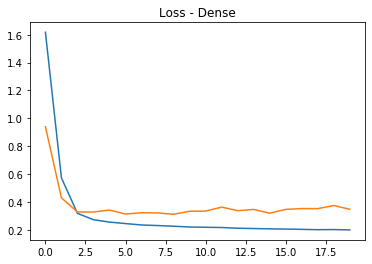

In [16]:
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss - Dense')

# RNN

In [19]:
modelRNN = Sequential()
modelRNN.add(layers.GRU(32, input_shape=(None, fp_data.shape[-1])))
modelRNN.add(layers.Dense(1))
modelRNN.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_2 (GRU)                  (None, 32)                4512      
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 33        
Total params: 4,545
Trainable params: 4,545
Non-trainable params: 0
_________________________________________________________________


In [20]:
modelRNN.compile(optimizer=RMSprop(), loss='mae')
historyRNN = modelRNN.fit_generator(train_gen,
                             steps_per_epoch=500,
                             epochs=20,
                             validation_data=val_gen,
                             validation_steps=val_steps)

Epoch 1/20
500/500 [==============================] - 153s 305ms/step - loss: 0.2973 - val_loss: 0.2708
Epoch 2/20
500/500 [==============================] - 151s 301ms/step - loss: 0.2825 - val_loss: 0.2681
Epoch 3/20
500/500 [==============================] - 151s 303ms/step - loss: 0.2765 - val_loss: 0.2689
Epoch 4/20
500/500 [==============================] - 149s 298ms/step - loss: 0.2727 - val_loss: 0.2653
Epoch 5/20
500/500 [==============================] - 150s 299ms/step - loss: 0.2683 - val_loss: 0.2668
Epoch 6/20
500/500 [==============================] - 149s 299ms/step - loss: 0.2655 - val_loss: 0.2633
Epoch 7/20
500/500 [==============================] - 149s 299ms/step - loss: 0.2597 - val_loss: 0.2671
Epoch 8/20
500/500 [==============================] - 150s 299ms/step - loss: 0.2574 - val_loss: 0.2663
Epoch 9/20
500/500 [==============================] - 150s 300ms/step - loss: 0.2525 - val_loss: 0.2657
Epoch 10/20
500/500 [==============================] - 150s 300m

## Loss
* After 5 epochs, validation error (orange) begins rising
* Indicative of overfitting, regularization will help training more epochs


Text(0.5, 1.0, 'Loss - RNN (GRU)')

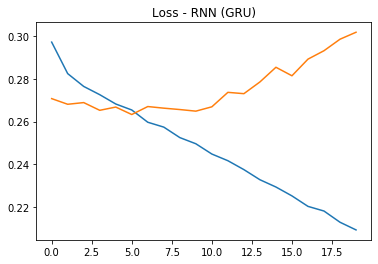

In [21]:
plt.plot(historyRNN.history['loss'], label='Train Loss')
plt.plot(historyRNN.history['val_loss'], label='Validation Loss')
plt.title('Loss - RNN (GRU)')

# RNN + Dropout
* Add recurrent dropout
* Train 40 epochs rather than 20


In [12]:
modelRNNOverfit = Sequential()
modelRNNOverfit.add(layers.GRU(32,
                        dropout=0.2, recurrent_dropout=0.2, 
                        input_shape=(None, fp_data.shape[-1])))
modelRNNOverfit.add(layers.Dense(1))
modelRNNOverfit.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_2 (GRU)                  (None, 32)                4512      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 33        
Total params: 4,545
Trainable params: 4,545
Non-trainable params: 0
_________________________________________________________________


In [13]:
modelRNNOverfit.compile(optimizer=RMSprop(), loss='mae')
historyRNNOverfit = modelRNNOverfit.fit_generator(train_gen,
                             steps_per_epoch=500,
                             epochs=20,
                             validation_data=val_gen,
                             validation_steps=val_steps)

Epoch 1/20
500/500 [==============================] - 168s 337ms/step - loss: 0.3358 - val_loss: 0.2783
Epoch 2/20
500/500 [==============================] - 165s 331ms/step - loss: 0.3175 - val_loss: 0.2740
Epoch 3/20
500/500 [==============================] - 165s 330ms/step - loss: 0.3085 - val_loss: 0.2762
Epoch 4/20
500/500 [==============================] - 165s 330ms/step - loss: 0.3052 - val_loss: 0.2702
Epoch 5/20
500/500 [==============================] - 165s 331ms/step - loss: 0.3016 - val_loss: 0.2675
Epoch 6/20
500/500 [==============================] - 165s 330ms/step - loss: 0.2981 - val_loss: 0.2695
Epoch 7/20
500/500 [==============================] - 168s 336ms/step - loss: 0.2970 - val_loss: 0.2679
Epoch 8/20
500/500 [==============================] - 166s 333ms/step - loss: 0.2951 - val_loss: 0.2666
Epoch 9/20
500/500 [==============================] - 169s 339ms/step - loss: 0.2915 - val_loss: 0.2671
Epoch 10/20
500/500 [==============================] - 168s 337m

## Loss
* Training loss (blue) continues to fall as expected with regularization -- dropout
* With dropout we're not seeing large increases in validation loss (orange)

Text(0.5, 1.0, 'Loss - RNN + Dropout (GRU)')

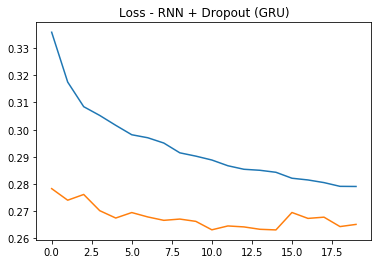

In [14]:
plt.plot(historyRNNOverfit.history['loss'], label='Train Loss')
plt.plot(historyRNNOverfit.history['val_loss'], label='Validation Loss')
plt.title('Loss - RNN + Dropout (GRU)')

# RNN Stacked + Dropout
* Add capacity to network since regularization is allowing us to train without overfitting
* Stack a second GRU Layer
* Continue using Dropout
* Training time will increase quite a bit with the additional GRU layer

In [20]:
modelRNNStacked = Sequential()
modelRNNStacked.add(layers.GRU(32,
                        dropout=0.1, recurrent_dropout=0.5, 
                        return_sequences=True,
                        input_shape=(None, fp_data.shape[-1])))
modelRNNStacked.add(layers.GRU(64,
                        dropout=0.1, recurrent_dropout=0.5))
modelRNNStacked.add(layers.Dense(1))
modelRNNStacked.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_9 (GRU)                  (None, None, 32)          4512      
_________________________________________________________________
gru_10 (GRU)                 (None, 64)                18624     
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 65        
Total params: 23,201
Trainable params: 23,201
Non-trainable params: 0
_________________________________________________________________


In [21]:
modelRNNStacked.compile(optimizer=RMSprop(), loss='mae')
historyRNNStacked = modelRNNStacked.fit_generator(train_gen,
                             steps_per_epoch=500,
                             epochs=5,
                             validation_data=val_gen,
                             validation_steps=val_steps)

Epoch 1/5
500/500 [==============================] - 332s 665ms/step - loss: 0.3397 - val_loss: 0.2811
Epoch 2/5
500/500 [==============================] - 331s 662ms/step - loss: 0.3175 - val_loss: 0.2783
Epoch 3/5
500/500 [==============================] - 331s 663ms/step - loss: 0.3118 - val_loss: 0.2715
Epoch 4/5
500/500 [==============================] - 331s 663ms/step - loss: 0.3035 - val_loss: 0.2685
Epoch 5/5
500/500 [==============================] - 332s 663ms/step - loss: 0.3001 - val_loss: 0.2878


## Loss

Text(0.5, 1.0, 'Loss - RNN + Dropout + Stacked (GRU, GRU)')

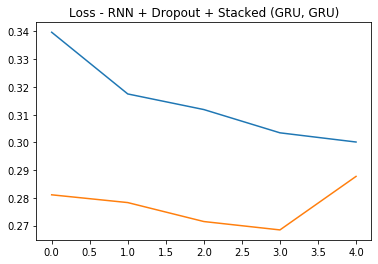

In [22]:
plt.plot(historyRNNStacked.history['loss'], label='Train Loss')
plt.plot(historyRNNStacked.history['val_loss'], label='Validation Loss')
plt.title('Loss - RNN + Dropout + Stacked (GRU, GRU)')